In [9]:
import Matrix
import math
import matplotlib.pyplot as plt
import copy
import numpy as np


def u_0_y_t(y, t, a):
    return math.sinh(y) * math.exp(-3 * a * t)


def u_pi4_y_t(y, t, a):
    return 0


def u_x_0_t(x, t, a):
    return 0


def u_x_ln2_t(x, t, a):
    return 0.75 * math.cos(2 * x) * math.exp(-3 * a * t)


def u_x_y_0(x, y, a):
    return math.cos(2 * x) * math.sinh(y)


def solve_f(x, y, t, a):
    return math.cos(2 * x) * math.sinh(y) * math.exp(-3 * a * t)


class ParabolicSolver2D:
    """ 6 вариант """
    def __init__(self, h1, h2, r, x_interval, y_interval, t_interval, a=1):
        self.a = a
        self.x_beg = x_interval[0]
        self.x_end = x_interval[1]
        self.y_beg = y_interval[0]
        self.y_end = y_interval[1]
        self.t_beg = t_interval[0]
        self.t_end = t_interval[1]
        self.h1 = h1
        self.h2 = h2
        self.r = r
        self.N = int((x_interval[1] - x_interval[0]) / h1)
        self.M = int((y_interval[1] - y_interval[0]) / h2)
        self.K = int((t_interval[1] - t_interval[0]) / r)
        self.u = [[[0 for column in range(self.N + 1)] for row in range(self.M + 1)] for time in range(self.K + 1)]

    def _borders_filling(self):
        # t = 0
        for i in range(self.M + 1):
            for j in range(self.N + 1):
                self.u[0][i][j] = u_x_y_0(j * self.h1, i * self.h2, a=self.a)
        # x = 0 and x = pi / 4
        for k in range(self.K + 1):
            for i in range(self.M + 1):
                self.u[k][i][0] = u_0_y_t(i * self.h2, k * self.r, a=self.a)
                self.u[k][i][self.N] = u_pi4_y_t(i * self.h2, k * self.r, a=self.a)
        # y = 0 and y = ln2
        for k in range(self.K + 1):
            for j in range(self.N + 1):
                self.u[k][0][j] = u_x_0_t(j * self.h1, k * self.r, a=self.a)
                self.u[k][self.M][j] = u_x_ln2_t(j * self.h1, k * self.r, a=self.a)

    def Analytical_solution(self):
        u = [[[0 for column in range(self.N + 1)] for row in range(self.M + 1)] for time in range(self.K + 1)]
        for k in range(0, self.K + 1):
            for i in range(0, self.M + 1):
                for j in range(0, self.N + 1):
                    u[k][i][j] = solve_f(j * self.h1, i * self.h2)
        return u

    def variable_directions(self):
        self._borders_filling()
        h1 = self.h1
        h2 = self.h2
        r = self.r
        a = self.a
        for k in range(1, self.K + 1):
            # k + 1/2
            u_1_2 = [[self.u[k - 1][row][column] for column in range(self.N + 1)] for row in range(self.M + 1)]
            for i in range(1, self.M):
                m = [[0 for j in range(0, self.N + 1)] for i in range(0, self.N + 1)]
                d = [0 for j in range(0, self.N + 1)]
                m[0][0] = 1
                d[0] = math.sinh(i * h2) * math.exp(-3 * a * (k - 1/2) * r)
                m[self.N][self.N] = 1
                d[self.N] = 0
                for j in range(1, self.N):
                    m[j][j - 1] = -a / (h1 ** 2)
                    m[j][j] = 2 / r + 2 * a / (h1 ** 2)
                    m[j][j + 1] = -a / (h1 ** 2)
                    d[j] = a * (self.u[k - 1][i + 1][j] - 2 * self.u[k - 1][i][j] + self.u[k - 1][i - 1][j]) / (h2 ** 2) + 2 * self.u[k - 1][i][j] / r
                matrix = Matrix.Matrix(l=m)
                row = matrix.tridiag_solve_SLAU(d)
                u_1_2[i] = row
            # k + 1
            for j in range(1, self.N):
                m = [[0 for j in range(0, self.M + 1)] for i in range(0, self.M + 1)]
                d = [0 for i in range(0, self.M + 1)]
                m[0][0] = 1
                d[0] = 0
                m[self.M][self.M] = 1
                d[self.M] = 0.75 * math.cos(2 * j * h1) * math.exp(-3 * a * k * r)
                for i in range(1, self.M):
                    m[i][i - 1] = -a * r / (2 * h2 ** 2)
                    m[i][i] = 1 + a * r / (h2 ** 2)
                    m[i][i + 1] = -a * r / (2 * h2 ** 2)
                    d[i] = u_1_2[i][j] + a * (r / 2) * (u_1_2[i][j - 1] - 2 * u_1_2[i][j] + u_1_2[i][j + 1]) / (h2 ** 2)
                matrix = Matrix.Matrix(l=m)
                column = matrix.tridiag_solve_SLAU(d)
                for i in range(self.M + 1):
                    self.u[k][i][j] = column[i]

    def fractional_steps(self):
        self._borders_filling()
        h1 = self.h1
        h2 = self.h2
        r = self.r
        a = self.a
        for k in range(1, self.K + 1):
            # k + 1/2
            u_1_2 = [[self.u[k - 1][row][column] for column in range(self.N + 1)] for row in range(self.M + 1)]
            for i in range(1, self.M):
                m = [[0 for j in range(0, self.N + 1)] for i in range(0, self.N + 1)]
                d = [0 for j in range(0, self.N + 1)]
                m[0][0] = 1
                d[0] = math.sinh(i * h2) * math.exp(-3 * a * (k - 1/2) * r)
                m[self.N][self.N] = 1
                d[self.N] = 0
                for j in range(1, self.N):
                    m[j][j - 1] = -a * r / (h1 ** 2)
                    m[j][j] = 1 + 2 * a * r / (h1 ** 2)
                    m[j][j + 1] = -a * r / (h1 ** 2)
                    d[j] = self.u[k - 1][i][j]
                matrix = Matrix.Matrix(l=m)
                row = matrix.tridiag_solve_SLAU(d)
                u_1_2[i] = row
            # k + 1
            for j in range(1, self.N):
                m = [[0 for j in range(0, self.M + 1)] for i in range(0, self.M + 1)]
                d = [0 for i in range(0, self.M + 1)]
                m[0][0] = 1
                d[0] = 0
                m[self.M][self.M] = 1
                d[self.M] = 0.75 * math.cos(2 * j * h1) * math.exp(-3 * a * k * r)
                for i in range(1, self.M):
                    m[i][i - 1] = -a * r / (h2 ** 2)
                    m[i][i] = 1 + 2 * a * r / (h2 ** 2)
                    m[i][i + 1] = -a * r / (h2 ** 2)
                    d[i] = u_1_2[i][j]
                matrix = Matrix.Matrix(l=m)
                column = matrix.tridiag_solve_SLAU(d)
                for i in range(self.M + 1):
                    self.u[k][i][j] = column[i]

    def y_const_plot(self, interval, t):
        fig = plt.figure(figsize=(10, 80))
        for k in range(interval[0], interval[1] + 1):
            ax = fig.add_subplot(interval[1] - interval[0] + 1, 1, k + 1 - interval[0])
            ax.set(ylim=[0, 1], xlim=[0, math.pi / 4])
            ax.set_title(f"const t = {t * self.r} const y = {self.h2 * k} шаг разбиения {self.h2}")
            x = [self.h1 * j for j in range(self.N + 1)]
            u_x = self.u[t][k]
            plt.plot(x, u_x)
            answ = [solve_f(x_elem, self.h2 * k, t * self.r, a=self.a) for x_elem in x]
            ax.plot(x, answ, color="black")
        plt.show()

    def x_const_plot(self, interval):
        t = self.K // 2
        fig = plt.figure(figsize=(10, 80))
        for j in range(interval[0], interval[1] + 1):
            ax = fig.add_subplot(interval[1] - interval[0] + 1, 1, j + 1 - interval[0])
            ax.set(ylim=[-1, 1], xlim=[0, math.log(2)])
            ax.set_title(f"const t = {t * self.r} const x = {self.h1 * j} шаг разбиения {self.h1} ")
            y = [self.h2 * k for k in range(self.M + 1)]
            u_y = [self.u[t][k][j] for k in range(self.M + 1)]
            plt.plot(y, u_y)
            answ = [solve_f(j * self.h1, y_elem, t * self.r, a=self.a) for y_elem in y]
            ax.plot(y, answ, color="black")
        plt.show()

    def get_error(self, t):
        error = 0
        for i in range(self.M + 1):
            for j in range(self.N + 1):
                error += abs(solve_f(j * self.h1, i * self.h2, t * self.r, a=self.a)) ** 2
        return math.sqrt(error) / (self.N * self.M)




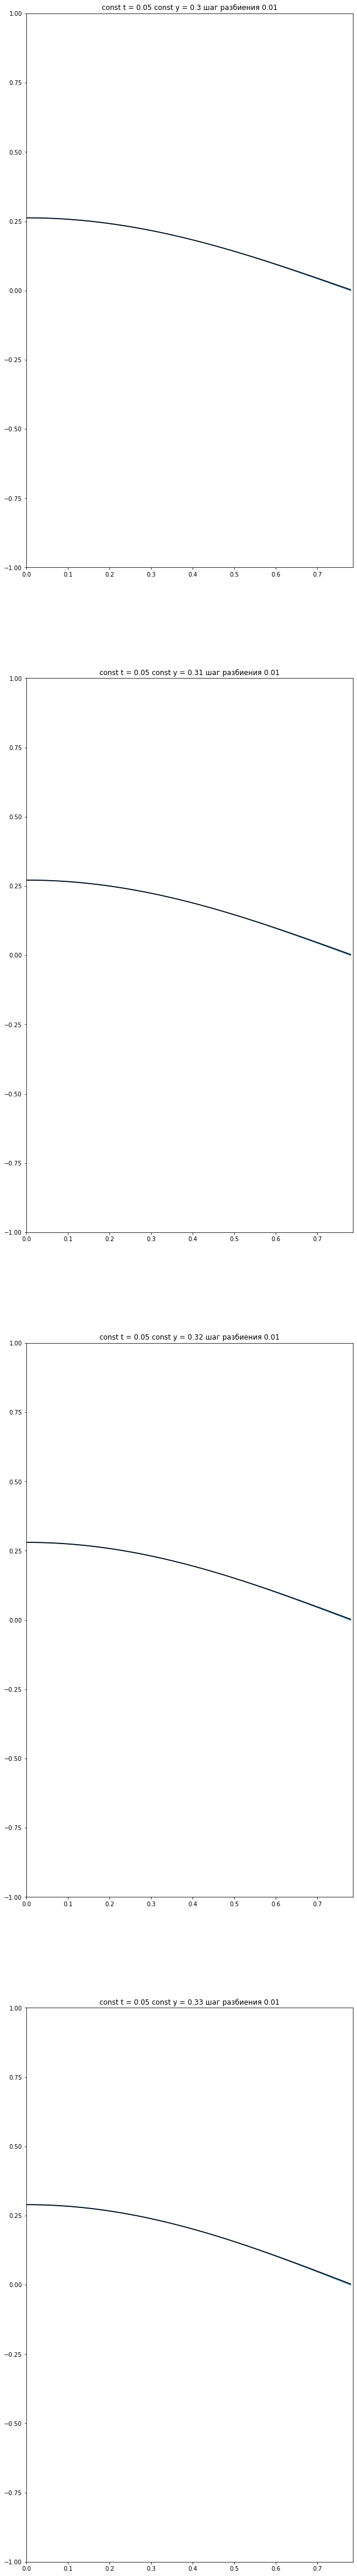

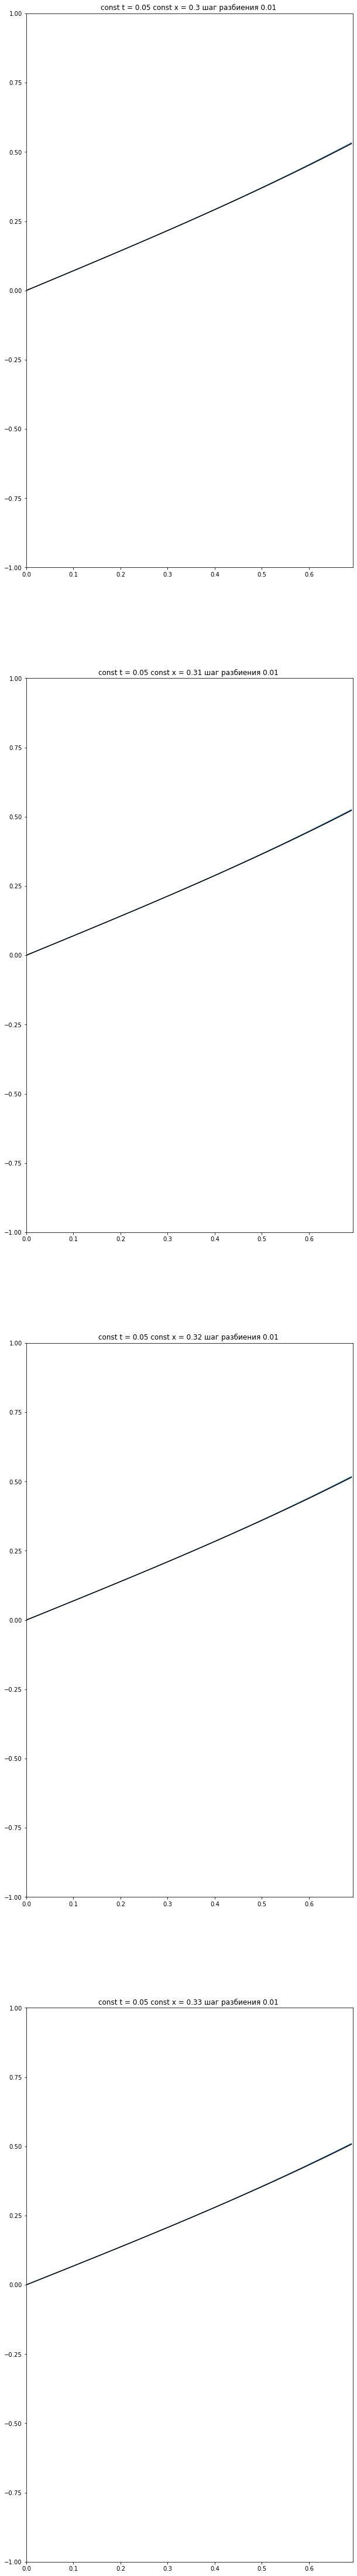

0.0041130466298345035
0.004112923240286466
0.004112799854440055
0.00411267647229516
0.004112553093851677
0.004112429719109492
0.004112306348068495
0.00411218298072857
0.004112059617089608
0.0041119362571515085


In [14]:
a = ParabolicSolver2D(0.01, 0.01, 0.001, [0, math.pi / 4], [0, math.log(2)], [0, 0.1], a=1)
a.fractional_steps()
a.y_const_plot([30, 33])
a.x_const_plot([30, 33])
for i in np.arange(0, 0.1, 0.01):
    print(a.get_error(i))

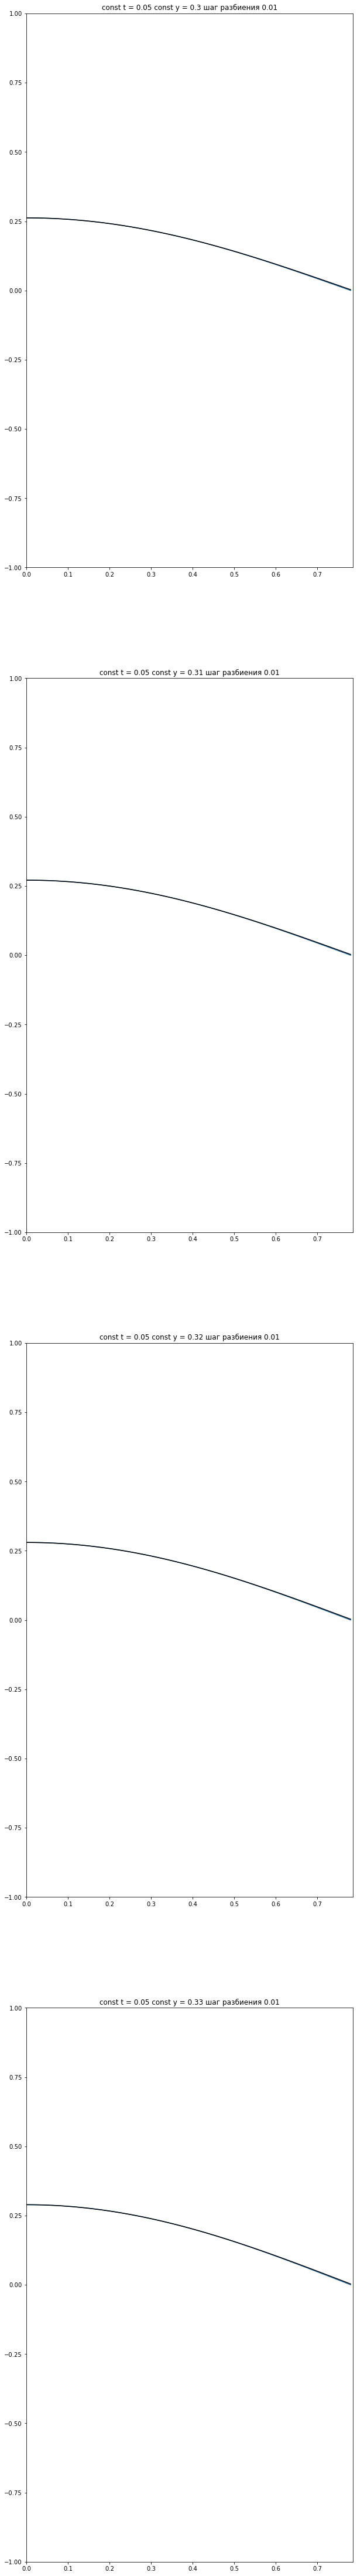

0.0041130466298345035
0.004112923240286466
0.004112799854440055
0.00411267647229516
0.004112553093851677
0.004112429719109492
0.004112306348068495
0.00411218298072857
0.004112059617089608
0.0041119362571515085


In [15]:
a = ParabolicSolver2D(0.01, 0.01, 0.001, [0, math.pi / 4], [0, math.log(2)], [0, 0.1], a=1)
a.variable_directions()
a.y_const_plot([30, 33])
for i in np.arange(0, 0.1, 0.01):
    print(a.get_error(i))

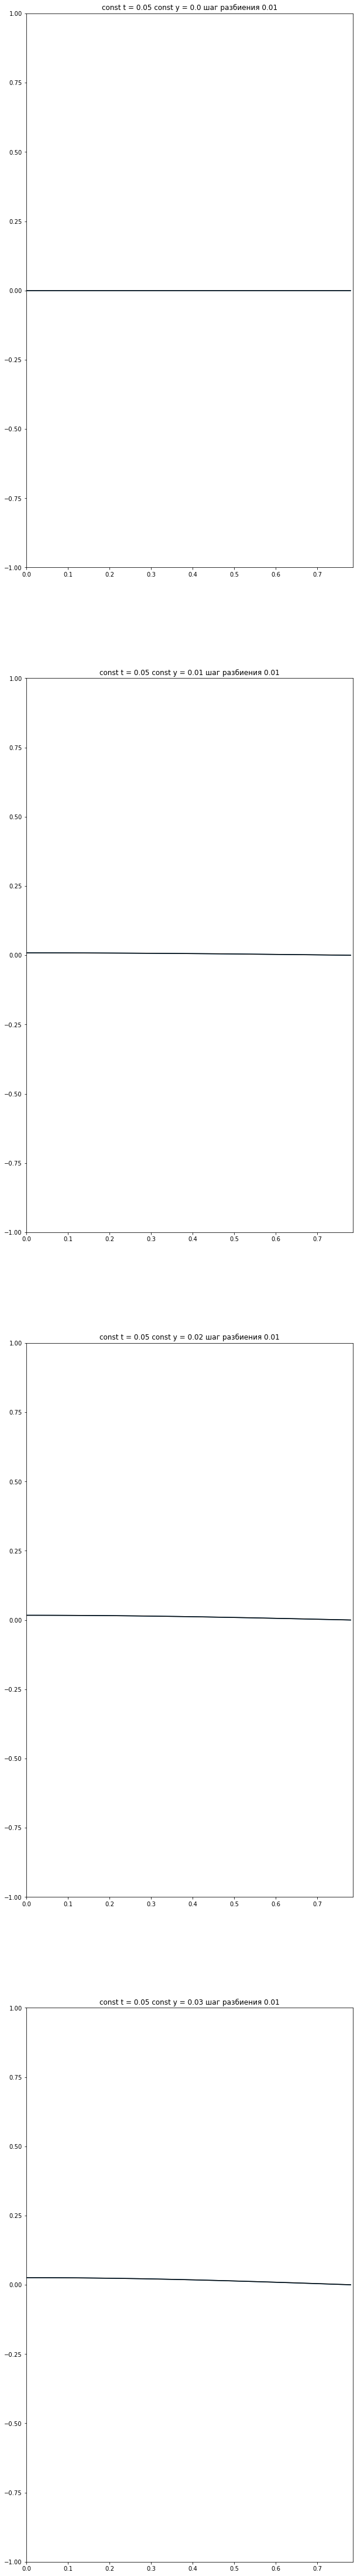

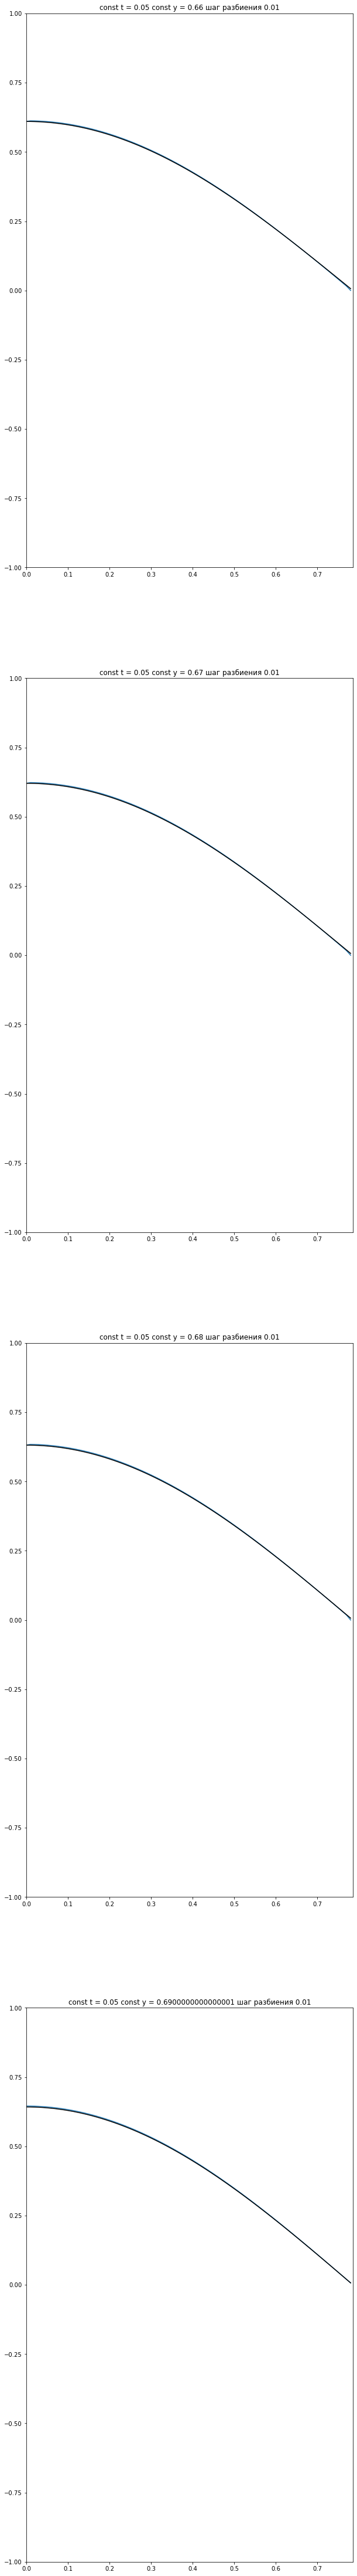

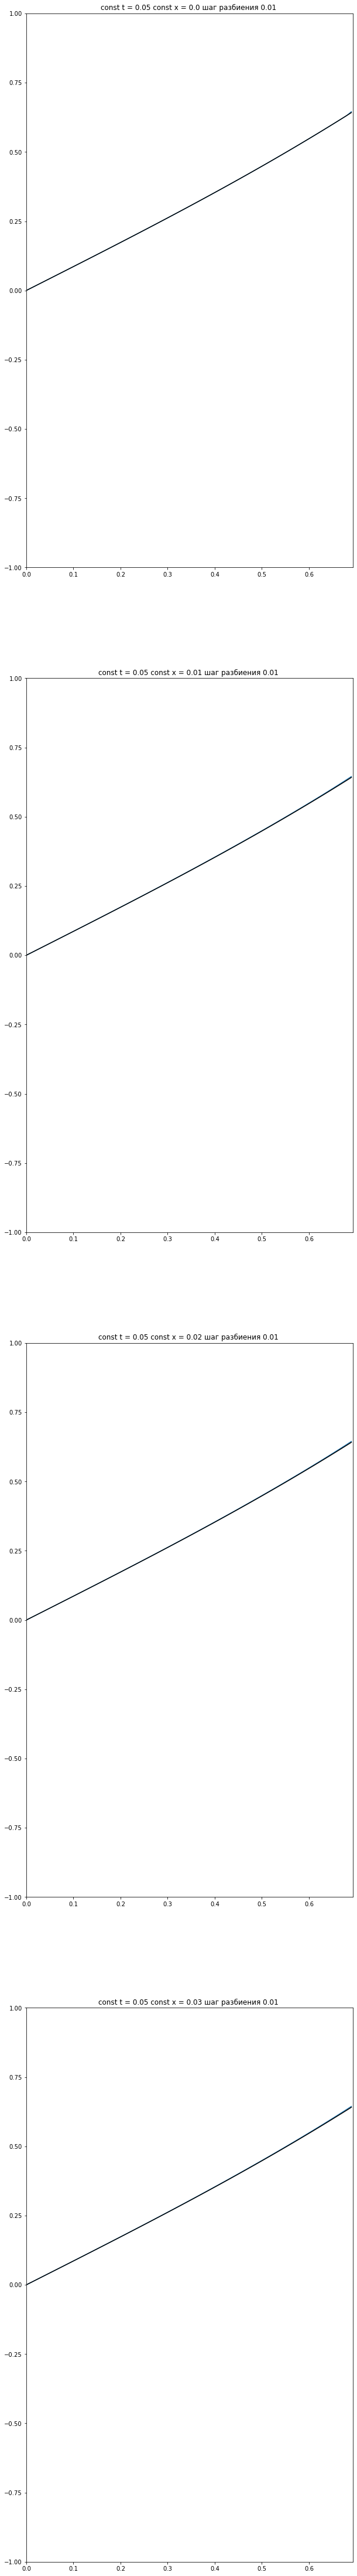

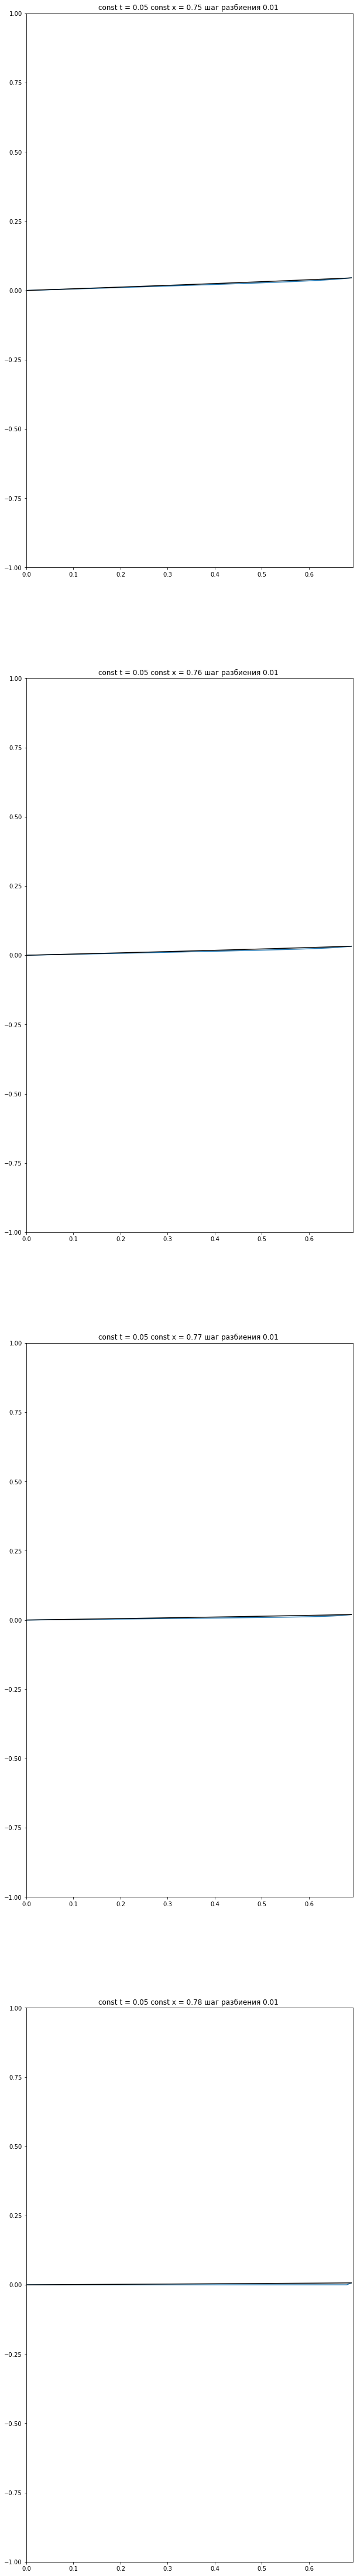

0.0041130466298345035
0.004112923240286466
0.004112799854440055
0.00411267647229516
0.004112553093851677
0.004112429719109492
0.004112306348068495
0.00411218298072857
0.004112059617089608
0.0041119362571515085


In [13]:
a = ParabolicSolver2D(0.01, 0.01, 0.001, [0, math.pi / 4], [0, math.log(2)], [0, 0.1], a=1)
a.fractional_steps()
a.y_const_plot([0, 3])
a.y_const_plot([66, 69])
a.x_const_plot([0, 3])
a.x_const_plot([75, 78])

for i in np.arange(0, 0.1, 0.01):
    print(a.get_error(i))

0.0041130466298345035


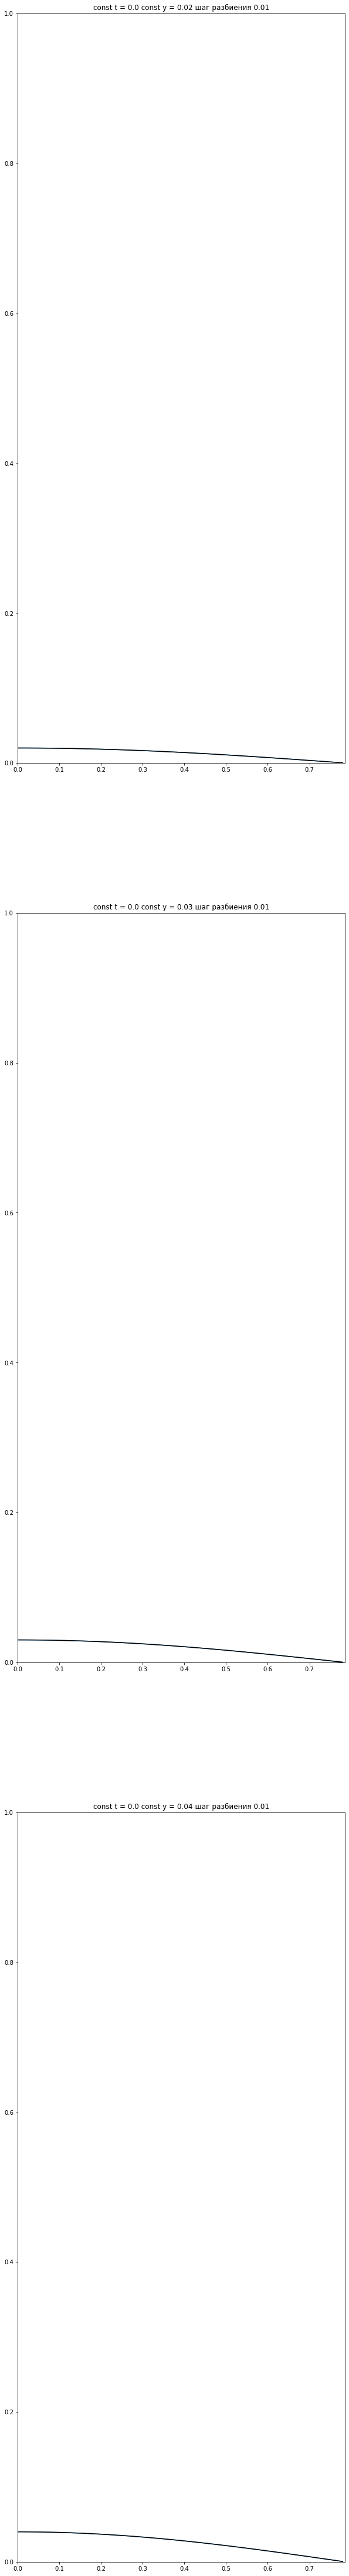

0.003873521440956364


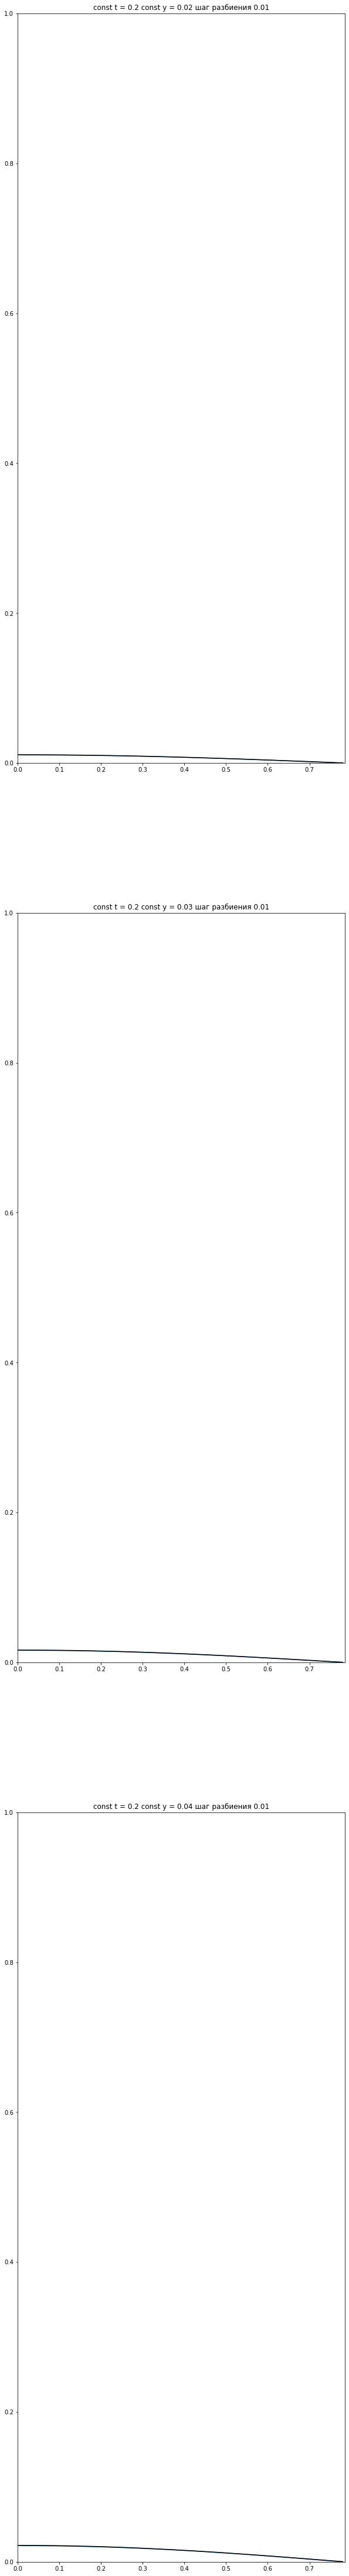

0.00364794511317085


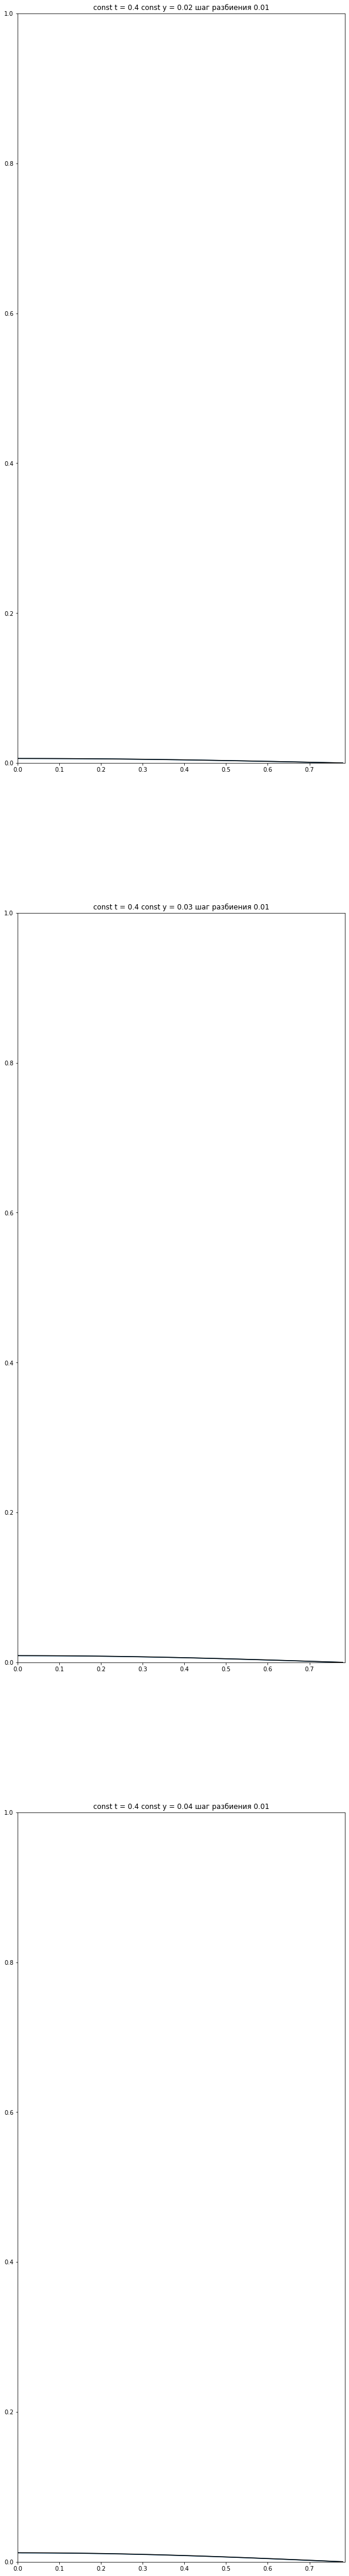

0.003435505328046286


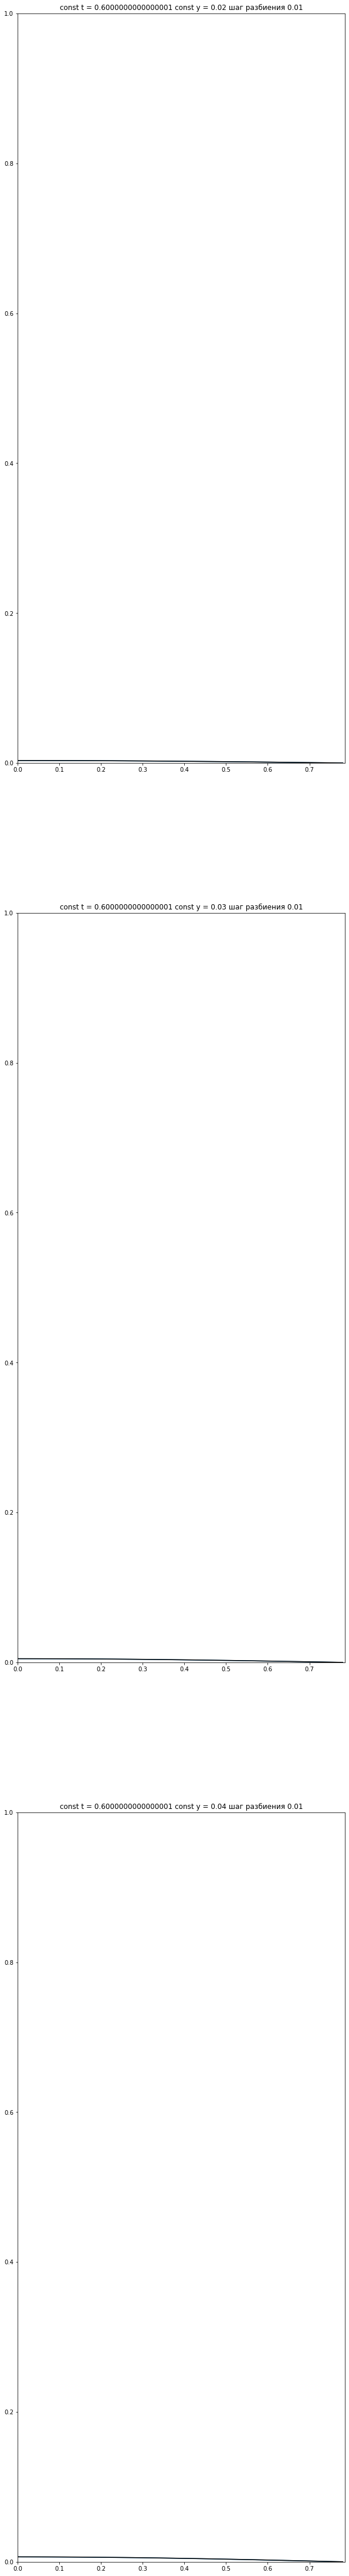

0.0032354370728937126


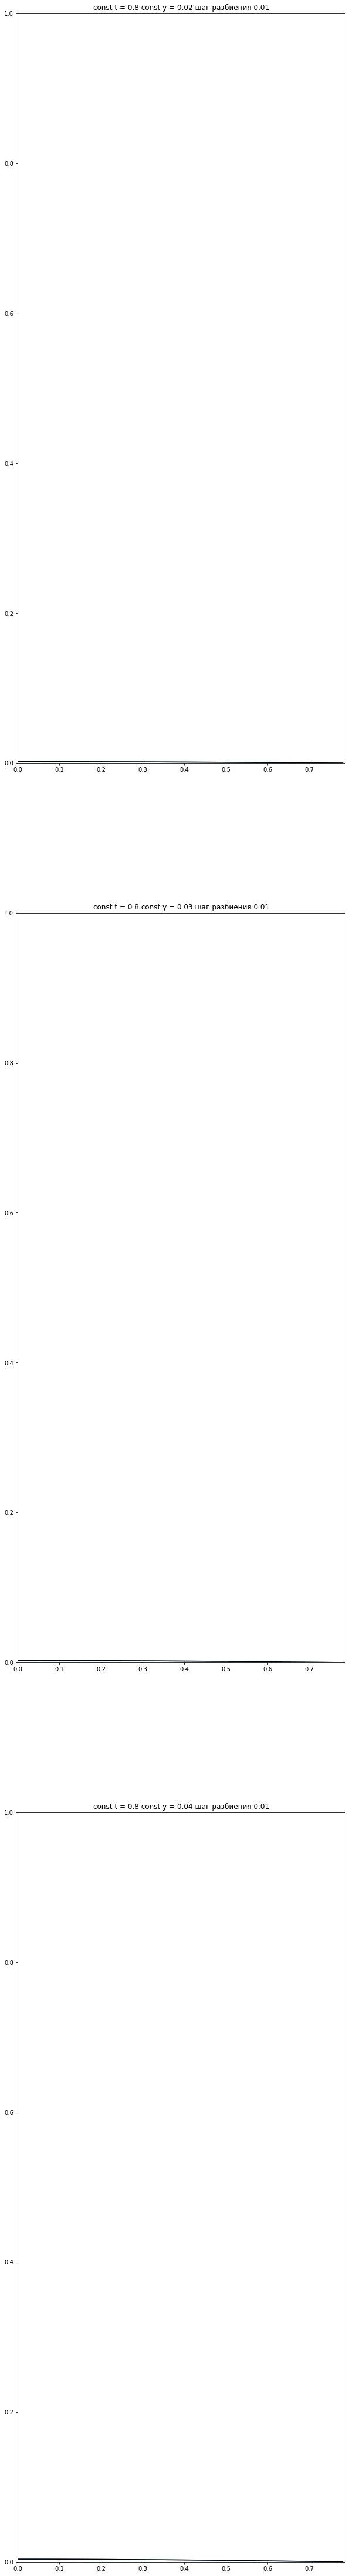

In [18]:
a = ParabolicSolver2D(0.01, 0.01, 0.1, [0, math.pi / 4], [0, math.log(2)], [0, 1], a=1)
a.variable_directions()


for i in np.arange(0, 1, 0.2):
    print(a.get_error(i))
    a.y_const_plot([2, 4], t=int(i * 10))